#### TIC ID's

- success 01: TIC 248853232 (gas giant)
- success 02: TIC 86263325 (gas giant)
- success 03: TIC 427685831 (gas giant)
- success 04: TIC 455784423 (gas giant)
- success 05: TIC 243921117 (gas giant)
- success 06: TIC 21744120 (gas giant)
- success 07: TIC 198108326 (gas giant)
- success 08: TIC 158588995 (neptune like)
- success 09: TIC 19028197 (neptune like)
- success 10: TIC 259377017.01 (sub neptune)

gas giant > 6 R🜨 > neptune like > 4 R🜨 > sub neptune > 2 R🜨 > super earth > 1.5 R🜨 > terrestrial

In [1]:
TIC = str(f"TIC {input("TIC: ")}")

TIC:  259377017


In [2]:
%matplotlib widget
import statistics
import matplotlib.pyplot as plt
import lightkurve as lk
import numpy as np
from scipy import stats
from astropy import units as u
from lightkurve import search_targetpixelfile
from lightkurve import search_tesscut
from lightkurve import LightCurve
from astroquery.mast import Catalogs

In [3]:
def import_data(TIC):    
    all_data = lk.search_lightcurve(TIC, author = "SPOC", exptime = "short")

    sectors_list = []
    for sector in all_data.table:
        sectors_list.append(int(sector["sequence_number"]))

    all_years = []
    for each in all_data:
        all_years.append(each.year.item())
    yr_count = np.bincount(all_years)
    yr_mode = np.argmax(yr_count)
    year_mask = (all_data.table["year"] == yr_mode)
    #year_mask = (all_data.table["year"] >= median_year - 1) & (all_data.table["year"] <= median_year + 1)
    selected_data = all_data[year_mask]
    stitch_me = lk.search_lightcurve(TIC, author = "SPOC", exptime = "short", sector = sectors_list)[year_mask].download_all()
    
    return sectors_list, selected_data, stitch_me
sectors, selected_data, stitch_me = import_data(TIC)

selected_data

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,TESS Sector 03,2018,SPOC,120,259377017,0.0
1,TESS Sector 04,2018,SPOC,120,259377017,0.0
2,TESS Sector 05,2018,SPOC,120,259377017,0.0


<Axes: xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

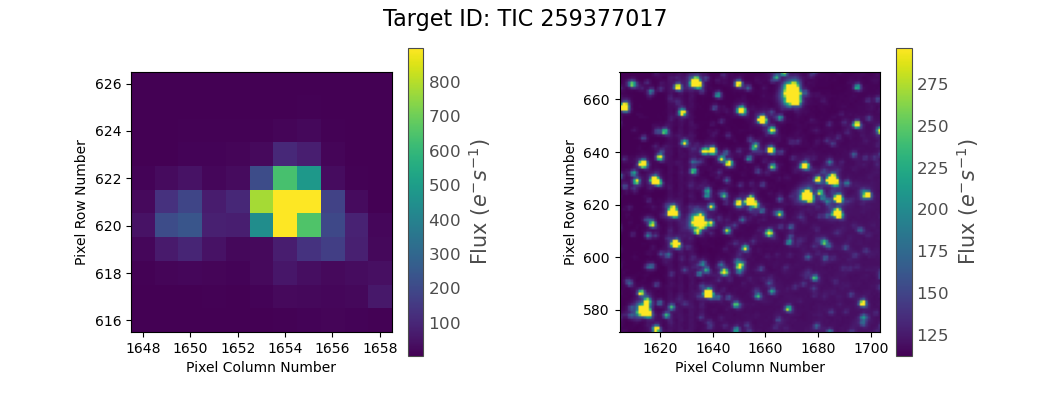

In [4]:
fig, (ax1, ax2) = plt.subplots(nrows = 1 ,ncols = 2, figsize = (10.5, 4))
fig.suptitle(f"Target ID: {TIC}", fontsize = 16)
fig.subplots_adjust(wspace = .5)

px_file = search_targetpixelfile(TIC, author = "SPOC", exptime = "short", sector = sectors[0]).download()
px_file.plot(ax = ax1, title = "")

ff_file = search_tesscut(TIC, sector = sectors[0]).download(cutout_size = 99)
ff_file.plot(ax = ax2, title = "")

<Axes: xlabel='Time - 2457000 [BTJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

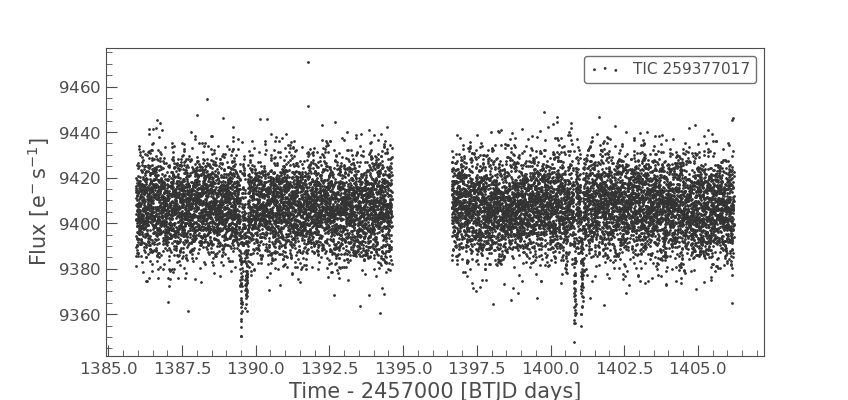

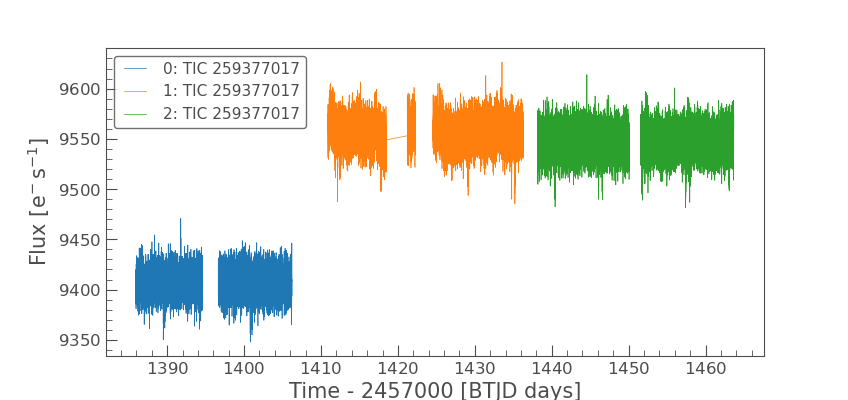

In [5]:
ts_first = lk.search_lightcurve(TIC, author = "SPOC", exptime = "short", sector = sectors[0]).download()

if len(sectors) > 1:
    fold_me = stitch_me.stitch().flatten().remove_nans()
else:
    fold_me = ts_first.flatten().remove_nans()

ts_first.scatter()
stitch_me.plot()

candidate 1 orbital period: 5.66 days
candidate 2 orbital period: 11.38 days
candidate 3 orbital period: 3.36 days


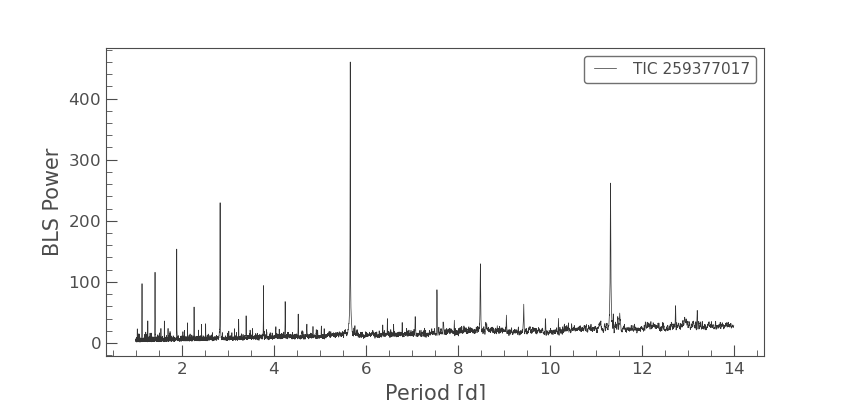

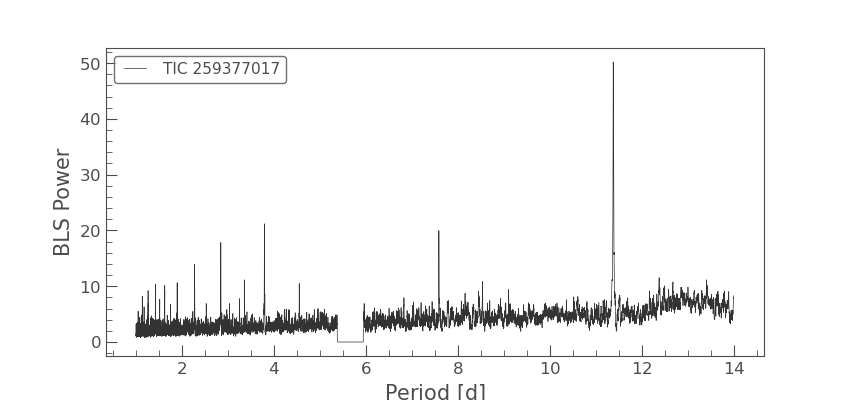

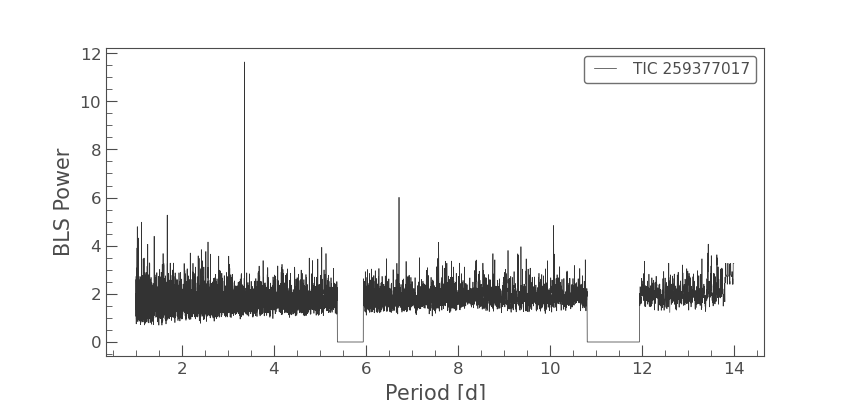

In [26]:
def periodogram_function(fold_me, exclusions, i):
    search_duration = np.linspace(.05, .4, 30)
    search_period = np.logspace(np.log10(1), np.log10(14), 15000) 
    periodogram = fold_me.to_periodogram(method = "bls", period = search_period, duration = search_duration)
    
    if exclusions:
        for each in exclusions:
            periodogram.power[~each] = 0
            
    orbital_period = periodogram.period_at_max_power
    transit_time = periodogram.transit_time_at_max_power
    transit_duration = periodogram.duration_at_max_power
    periodogram.plot()        
    print(f"candidate {i + 1} orbital period: {round(orbital_period.value, 2)} days")
    return periodogram, orbital_period, transit_time, transit_duration

def test_harmonics(prev_fold_me, prev_periodogram, prev_period, prev_time):
    phased_lc = prev_fold_me.fold(period = prev_period, epoch_time = prev_time)
    binned_lc = phased_lc.bin(30/60/24)
    
    greatest_min = binned_lc.flux.value.min()
    transit_depth = 1 - greatest_min
    transit_threshold = greatest_min + (transit_depth * .35)
    below = (binned_lc.flux.value < transit_threshold)
    min_duration = 2
    transit_length = 0
    transit_count = 0

    for flux in below:
        if flux:
            transit_length += 1
        elif transit_length >= min_duration:
            transit_count += 1
            transit_length = 0

    if transit_count == 1:
        detected_planet = True
    else:
        detected_planet = False
    return detected_planet, phased_lc
    
def next_function(prev_fold_me, prev_periodogram, prev_period, prev_time, prev_duration):
    mask = prev_periodogram.get_transit_mask(period = prev_period, transit_time = prev_time, duration = prev_duration)
    next_fold_me = prev_fold_me[~mask]

    exclude = (prev_periodogram.period < prev_period * .95) | (prev_periodogram.period > prev_period * 1.05) 
    prev_periodogram.power[~exclude] = 0
    return next_fold_me, exclude

candidates = [fold_me]
exclusions = []
exoplanets = []

i = 0
potential_candidate = True
while potential_candidate:
    periodogram, orbital_period, transit_time, transit_duration = periodogram_function(candidates[i], exclusions, i) 
    detected_planet, phased_lc = test_harmonics(candidates[i], periodogram, orbital_period, transit_time)
    if detected_planet == True:
        exoplanets.append({"period": orbital_period, "t0": transit_time, "duration": transit_duration})
    next_fold_me, exclude = next_function(candidates[i], periodogram, orbital_period, transit_time, transit_duration)
    candidates.append(next_fold_me)
    exclusions.append(exclude)     
    if i != 0:
        redundant_check = candidates[i].fold(period = orbital_period, epoch_time = transit_time)
        center = (-0.01 * u.day < redundant_check.phase) & (redundant_check.phase < 0.01 * u.day)
        if np.median(redundant_check.flux[center]) > 0 and periodogram.max_power > 10: 
            potential_candidate = True
        else:
            potential_candidate = False
    i += 1

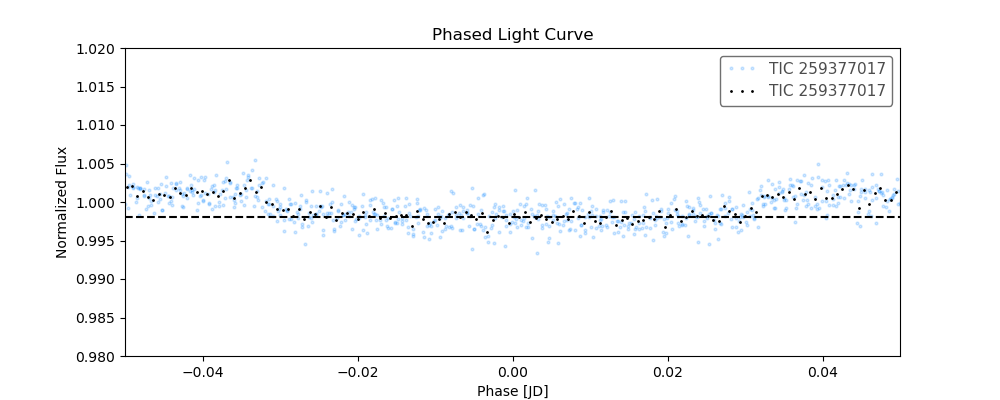

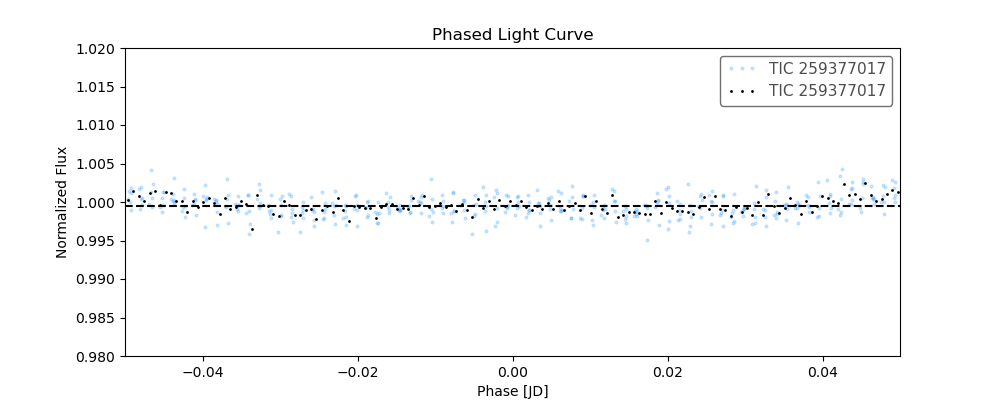

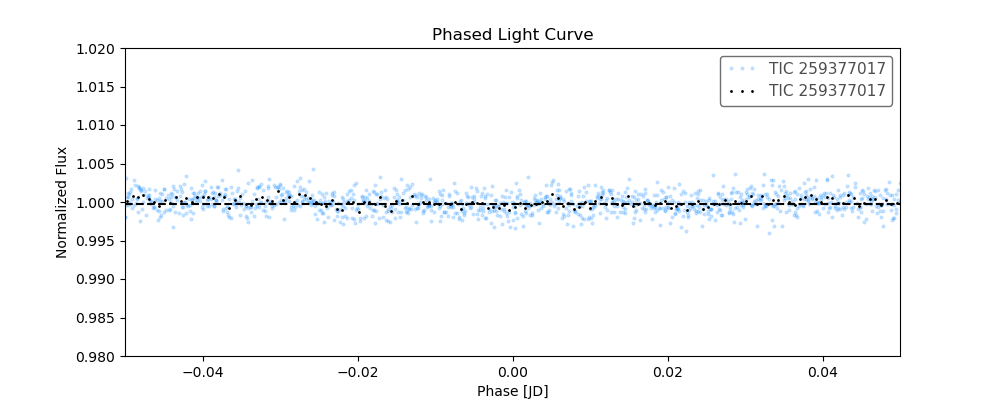

In [28]:
def plot_light_curve(fold_me, period, t0):
    phased_lc = fold_me.fold(period = period, epoch_time = t0)
    binned_lc = phased_lc.bin(1/60/24)
    phase_points = (-0.01 * u.day < phased_lc.phase) & (phased_lc.phase < 0.01 * u.day)
    dip = np.mean(phased_lc.flux[phase_points])
    depth = 1 - dip.value
    #print(f"transit depth: {round(depth, 2)} percent")
    
    fig, ax = plt.subplots(figsize = (10,4))
    phased_lc.plot(ax = ax, linewidth = '0', marker = "o", color = "dodgerblue", alpha = .2)
    binned_lc.plot(ax = ax, linewidth = '0', marker = '.', color = "black")
    plt.axhline(dip, color = 'black', linestyle = '--')
    plt.title("Phased Light Curve")
    plt.xlim(-.05,.05)
    plt.ylim(.98, 1.02)
    plt.show()
    return depth

for each in exoplanets:
    plot_light_curve(fold_me, each["period"], each["t0"])

In [ ]:
star = Catalogs.query_object(TIC, catalog = "TIC")
r_pl_solar_radius = np.sqrt(depth) * (star["rad"][0] * u.R_sun)
r_pl_earth_radius = r_pl_solar_radius.to(u.Rearth) 
# averge skew caused by bls, flattening, stellar data, cadence, etc.
if r_pl_earth_radius > (6 * u.Rearth):
    avg_skew = 0 #.08
elif r_pl_earth_radius > (2 * u.Rearth):
    avg_skew = 0 #.06
else:
    avg_skew = 0 #.04
r_pl_earth_radius = r_pl_solar_radius.to(u.Rearth) * (1 - avg_skew)
r_pl_jupiter_radius = r_pl_solar_radius.to(u.Rjupiter) * (1 - avg_skew)  

print('Radius:')
print(r_pl_earth_radius)
print(r_pl_jupiter_radius)

#### Ideas for improvement
- cut empty areas and count transits the divide by time not cut instead of 27?
- test false positives
- compare results with astroquery
- make only last plot show unless prompted at end for the rest
- add input option for kepler KIC